# Setup Requirements

## Import Libraries

In [1]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

## Specify Paths

In [2]:
dataset_path = 'model/data/data.csv'
model_save_path = 'model/model.keras'
tflite_save_path = 'model/model.tflite'
label_path = 'model/data/label.csv'

## Setup Attributes

In [3]:
DIMENSION = 2

NUM_CLASSES = 50

# Preprocess Data

## Load Data

In [4]:
X_dataset = np.loadtxt(dataset_path, delimiter=',', dtype='float32', usecols=list(range(1, (21 * DIMENSION) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset_path, delimiter=',', dtype='int32', usecols=(0))

## Split Train/Test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.8, random_state=RANDOM_SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75, random_state=RANDOM_SEED)

# Build Model

## Construct Model

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * DIMENSION, )),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

## Compile Model

In [8]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


## Setup Callbacks

In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=1)

## Summary

In [10]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               5504      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 50)                1650      
                                                                 
Total params: 17,490
Trainable params: 17,490
Non-traina

# Train Model

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_val, y_val),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/50
6994/7050 [============================>.] - ETA: 0s - loss: 0.4543 - accuracy: 0.8538
Epoch 1: saving model to model\model.keras
7050/7050 [==============================] - 11s 1ms/step - loss: 0.4515 - accuracy: 0.8547 - val_loss: 0.0178 - val_accuracy: 0.9967
Epoch 2/50
7006/7050 [============================>.] - ETA: 0s - loss: 0.0725 - accuracy: 0.9766
Epoch 2: saving model to model\model.keras
7050/7050 [==============================] - 10s 1ms/step - loss: 0.0723 - accuracy: 0.9767 - val_loss: 0.0070 - val_accuracy: 0.9983
Epoch 3/50
7017/7050 [============================>.] - ETA: 0s - loss: 0.0452 - accuracy: 0.9859
Epoch 3: saving model to model\model.keras
7050/7050 [==============================] - 10s 1ms/step - loss: 0.0451 - accuracy: 0.9859 - val_loss: 0.0041 - val_accuracy: 0.9986
Epoch 4/50
7022/7050 [============================>.] - ETA: 0s - loss: 0.0365 - accuracy: 0.9883
Epoch 4: saving model to model\model.keras
7050/7050 [=======================

# Evaluate Model

## Plot Confusion Matrix

In [12]:
with open(label_path,encoding='utf-8-sig') as f:
		classifier_labels = csv.reader(f)
		classifier_labels = [
			row[0] for row in classifier_labels
		]

In [13]:
print(classifier_labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'Hi', 'Good', 'Bad', 'how are', 'you', 'my ', 'name ', 'nice to', 'meet', 'you', 'what is ', "I'm fine", 'thanks ', 'everyone', 'today', 'we will', 'present', 'our ', 'app', 'to help', 'deaf', 'people', 'hope ', 'like ']


588/588 [==============================] - 1s 906us/step


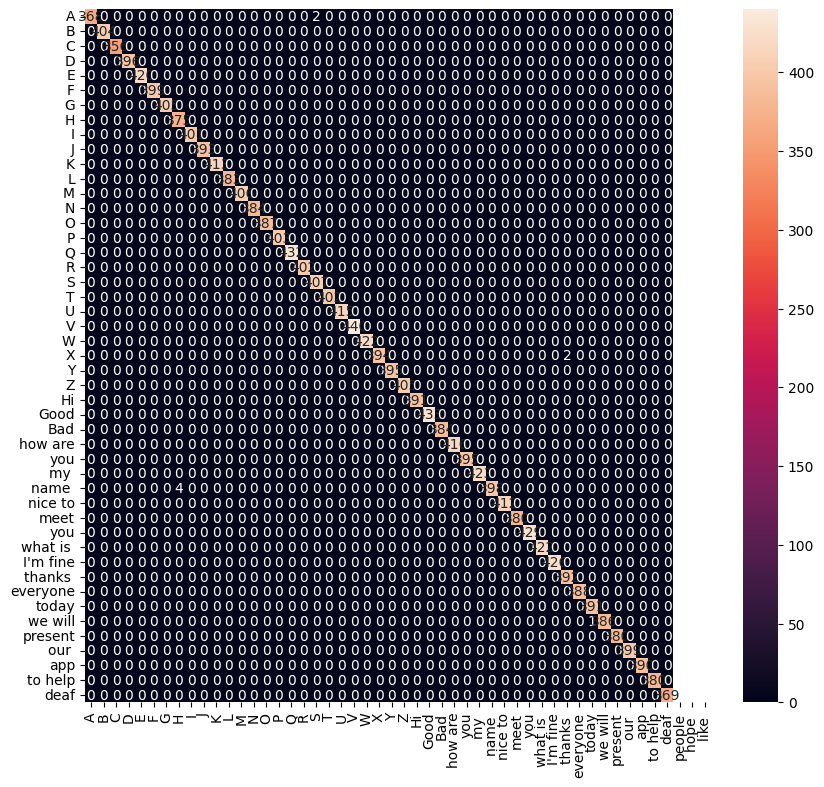

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       370
           1       1.00      1.00      1.00       404
           2       1.00      1.00      1.00       356
           3       1.00      1.00      1.00       396
           4       1.00      1.00      1.00       420
           5       1.00      1.00      1.00       399
           6       1.00      1.00      1.00       405
           7       0.99      1.00      0.99       375
           8       1.00      1.00      1.00       401
           9       1.00      1.00      1.00       393
          10       1.00      1.00      1.00       413
          11       1.00      1.00      1.00       383
          12       1.00      1.00      1.00       406
          13       1.00      1.00      1.00       384
          14       1.00      1.00      1.00       387
          15       1.00      1.00      1.00       403
          16       1.00      1.00      1.00       432
     

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(10, 9))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False, xticklabels=classifier_labels, yticklabels=classifier_labels)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)


## Accuracy and Loss

In [15]:
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=8)

2350/2350 [==============================] - 2s 905us/step - loss: 0.0017 - accuracy: 0.9995


## Predict Unseen Data

In [16]:
predict_result = model.predict(np.array([X_test[0]]))
print(predict_result)
print(np.squeeze(predict_result))
print(np.sum((predict_result)))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 23ms/step
[[1.1536064e-11 0.0000000e+00 6.3824187e-28 5.1228056e-28 0.0000000e+00
  0.0000000e+00 1.0623528e-37 0.0000000e+00 3.3653673e-19 1.0000000e+00
  0.0000000e+00 0.0000000e+00 4.7161765e-38 0.0000000e+00 9.8937332e-28
  0.0000000e+00 0.0000000e+00 0.0000000e+00 2.9368099e-30 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 7.7756665e-29 0.0000000e+00
  1.3119264e-21 0.0000000e+00 2.4808276e-30 0.0000000e+00 5.3837654e-22
  1.9955755e-24 2.9969671e-19 2.9815897e-23 0.0000000e+00 0.0000000e+00
  0.0000000e+00 6.5331506e-28 0.0000000e+00 3.7611111e-23 9.7913263e-17
  3.6117985e-16 2.8568909e-34 2.2284824e-34 3.2935709e-27 0.0000000e+00
  3.0681528e-13 0.0000000e+00 0.0000000e+00 1.0456908e-30 7.5338473e-29]]
[1.1536064e-11 0.0000000e+00 6.3824187e-28 5.1228056e-28 0.0000000e+00
 0.0000000e+00 1.0623528e-37 0.0000000e+00 3.3653673e-19 1.0000000e+00
 0.0000000e+00 0.0000000e+00 4.7161765e-38 0.0000000e+00 9.8937332e-28
 0.0000000e+0

# Convert TFLite

## Save Model

In [17]:
model.save(model_save_path)

## Load Model

In [18]:
model = tf.keras.models.load_model(model_save_path)

## Quantization & Save

In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)


INFO:tensorflow:Assets written to: C:\Users\leenh\AppData\Local\Temp\tmptwyea3o7\assets


72840

# Inference test

## Setup Interpreter Interface

In [20]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

## Get Tensor Details

In [21]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

## Implement Inference

### Setup Input Tensor

In [22]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

### Invoke Interpreter

In [23]:
%%time
interpreter.invoke()

CPU times: total: 0 ns
Wall time: 0 ns


### Get Tensor Output

In [24]:
tflite_results = interpreter.get_tensor(output_details[0]['index'])
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.1535997e-11 0.0000000e+00 6.3823941e-28 5.1227864e-28 0.0000000e+00
 0.0000000e+00 9.4039548e-38 0.0000000e+00 3.3653543e-19 1.0000000e+00
 0.0000000e+00 0.0000000e+00 4.7019774e-38 0.0000000e+00 9.8937332e-28
 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.9368098e-30 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 7.7755485e-29 0.0000000e+00
 1.3119164e-21 0.0000000e+00 2.4808086e-30 0.0000000e+00 5.3837245e-22
 1.9955524e-24 2.9969671e-19 2.9815780e-23 0.0000000e+00 0.0000000e+00
 0.0000000e+00 6.5331251e-28 0.0000000e+00 3.7611108e-23 9.7912509e-17
 3.6117845e-16 2.8568912e-34 2.2284655e-34 3.2935709e-27 0.0000000e+00
 3.0681295e-13 0.0000000e+00 0.0000000e+00 1.0456909e-30 7.5337908e-29]
9
